In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')
import os

In [ ]:
!pip install patool
import patoolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
#from tensorflow.keras.utils import load_img
#from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

In [ ]:
!pip install Data_Loading

In [ ]:
import pandas as pd
from tqdm import tqdm
from glob import glob

# Read the CSV file directly
for file in tqdm(glob('/content/drive/MyDrive/BDA/train.csv')):
    df = pd.read_csv(file)






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


In [ ]:
if 'df' not in globals():
    print("Variable 'df' is not defined.")

In [ ]:
x = df['comment_text']
y = df.drop(columns=['id', 'comment_text'], axis=1)
y = np.array(y)

In [ ]:
from tensorflow.keras.layers import TextVectorization # Preprocessing layer which maps text features to integer sequences
max_vocab = 50000 # No of words in vocab
vec = TextVectorization(max_tokens=max_vocab, output_sequence_length=1500, output_mode='int')
vec.adapt(x.values) # Create vocabulary for the text data in the x dataframe

In [ ]:
# vec.get_vocabulary()

vec('I am IronMan')[:4]
vectorized_data = vec(x.values)

In [ ]:
len(vec('I am IronMan'))

1500

In [ ]:
vectorized_data

<tf.Tensor: shape=(159571, 1500), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:
# Create tensorflow dataset object
data_pipeline = tf.data.Dataset.from_tensor_slices((vectorized_data, y))

# Cache the dataset in memory or disk for faster access during training
data_pipeline = data_pipeline.cache()

# Shuffles the dataset with a buffer size of 100000
data_pipeline = data_pipeline.shuffle(100000)

# Batch the data into groups of 16 samples
data_pipeline = data_pipeline.batch(16)

# next 8 batches of data will be prepared in the background while one batch is running
data_pipeline = data_pipeline.prefetch(8)


# Convert the dataset to a numpy iterator and receives next batch of data
data_pipeline.as_numpy_iterator().next()

(array([[ 526,  177,  214, ...,    0,    0,    0],
        [5348, 8001,   59, ...,    0,    0,    0],
        [1262,  803,  880, ...,    0,    0,    0],
        ...,
        [6584,   40,  388, ...,    0,    0,    0],
        [ 290,   65,   29, ...,    0,    0,    0],
        [4346,   16,   30, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [ ]:

# 70% for train, 20% for validation, 10% for test

train = data_pipeline.take(int(len(data_pipeline)*0.7))
val = data_pipeline.skip(int(len(data_pipeline)*0.7)).take(int(len(data_pipeline)*0.2))
test = data_pipeline.skip(int(len(data_pipeline)*0.9)).take(int(len(data_pipeline)*0.1))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier

# Assuming 'x' contains the text data and 'y' contains the labels
x = df['comment_text']
y = df.drop(columns=['id', 'comment_text'], axis=1)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert the label DataFrames to arrays
y_train_array = y_train.values
y_test_array = y_test.values

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression()

# Wrap Logistic Regression model with MultiOutputClassifier for multi-label classification
multi_target_model = MultiOutputClassifier(logistic_model, n_jobs=-1)

# Train the multi-target model
multi_target_model.fit(x_train_tfidf, y_train_array)

# Predict the labels
y_pred = multi_target_model.predict(x_test_tfidf)

# Print the classification report
print(classification_report(y_test_array, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      3056
           1       0.60      0.26      0.36       321
           2       0.92      0.63      0.75      1715
           3       0.76      0.18      0.29        74
           4       0.84      0.54      0.65      1614
           5       0.73      0.17      0.27       294

   micro avg       0.88      0.57      0.69      7074
   macro avg       0.79      0.40      0.51      7074
weighted avg       0.87      0.57      0.68      7074
 samples avg       0.06      0.05      0.05      7074



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding


max_vocab = 50000  # Example value, replace with your actual max_vocab


model = Sequential()  # Initialize a sequential model
model.add(Embedding(max_vocab+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          1600032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

model = Sequential()  # Initialize a sequential model
model.add(Embedding(max_vocab+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          1600032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
class CustomLSTM(LSTM):
    pass


In [ ]:
import tensorflow as tf

# Define custom objects if necessary
custom_objects = {"CustomLSTM": CustomLSTM}  # Define your custom layers if you have any

# Load the model
model_path = '/content/drive/MyDrive/BDA/toxicity.h5'  # Corrected file path
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)


In [ ]:
sample_text = vec('You are stupid')
sample_result = model.predict(np.expand_dims(sample_text, 0))
sample_result

1/1 [==============================] - 1s 1s/step


array([[9.8208302e-01, 4.9687689e-03, 7.7307236e-01, 9.0034679e-04,
        9.1504151e-01, 2.8340074e-03]], dtype=float32)

In [ ]:
df.columns[2:]

# toxic - 95%
# severe_toxic - 63%
# obscene - 77%a
# threat - 17%
# Insult - 50%
# identity_hate - 8%

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


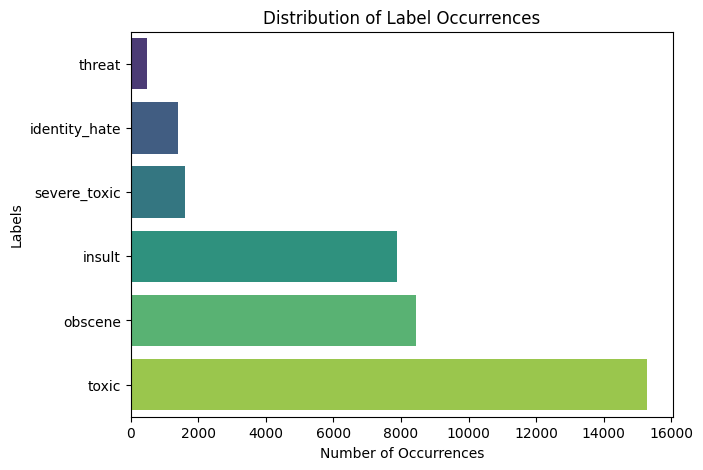

In [ ]:
import seaborn as sns
# Read the CSV file directly
for file in tqdm(glob('/content/drive/MyDrive/BDA/train.csv')):
    df = pd.read_csv(file)

# Assign the loaded data to the 'data' variable
data = df

# Visualizing the class distribution of the 'label' column
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()




# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()


In [ ]:
# Testing

x_test, y_test = test.as_numpy_iterator().next()
result = model.predict(x_test)

1/1 [==============================] - 0s 499ms/step


In [ ]:
result


array([[2.07771533e-04, 4.83915556e-15, 5.73761341e-08, 4.81301242e-07,
        3.89582237e-05, 1.08287695e-05],
       [6.77978434e-03, 4.46421095e-10, 4.05539104e-05, 2.01398987e-04,
        1.17916334e-03, 6.13425975e-04],
       [5.86583628e-04, 1.48543626e-14, 4.36373085e-07, 4.38991890e-07,
        6.77562275e-05, 7.18941465e-06],
       [5.61733432e-05, 2.02424215e-17, 6.34146291e-10, 3.60629748e-09,
        2.44196826e-06, 6.33377454e-07],
       [1.00136362e-03, 5.99265212e-13, 1.62282606e-06, 9.08894799e-06,
        1.46893202e-04, 5.65622977e-05],
       [2.61931700e-06, 3.17525577e-22, 3.46101359e-12, 3.31093139e-11,
        9.77396084e-08, 1.84100095e-08],
       [2.07824429e-04, 2.68626441e-15, 2.68920637e-08, 4.69119101e-07,
        3.23932763e-05, 1.35293185e-05],
       [5.51189942e-06, 8.16706680e-21, 1.94465208e-11, 4.91359287e-10,
        5.71829219e-07, 1.19810650e-07],
       [8.12986568e-02, 3.33346793e-06, 3.21441982e-03, 5.63243357e-03,
        1.89769063e-02, 

In [ ]:
ans = (result > 0.5).astype(int)
print("Predicted", ans)
print('Actual', y_test)

Predicted [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
Actual [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
precision = Precision()
recall = Recall()
cat_acc = CategoricalAccuracy()

counter = 0
for batch in test.as_numpy_iterator():

    # Unpacking
    x_test, y_test = batch
    pred_y = model.predict(x_test)
    y_test = y_test.flatten()
    pred_y = pred_y.flatten()

    # Update
    precision.update_state(y_test, pred_y)
    recall.update_state(y_test, pred_y)
    cat_acc.update_state(y_test, pred_y)

    counter += 1
    if(counter == 20):
        break


1/1 [==============================] - 0s 315ms/step


In [ ]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {cat_acc.result().numpy()}')
# model.save('toxicity.h5')

Precision: 0.875, Recall: 0.8513513803482056, Accuracy: 0.3499999940395355


In [ ]:
!pip install gradio jinja2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.7 MB/s e

In [ ]:
import gradio as gradio_gui

my_input = vec('You are awesome')
result = model.predict(np.expand_dims(my_input, 0))

ans = (result > 0.5).astype(int)

1/1 [==============================] - 0s 414ms/step


In [ ]:
import numpy as np

# Assuming my_input is your input data with shape (32,) or similar
my_input = np.array([1, 2, 3, ..., 30, 31, 32])  # Example input data

# Reshape the input to add a batch dimension
my_input_reshaped = my_input.reshape(1, -1)

# Now, my_input_reshaped has the shape (1, 32), where 1 represents the batch size


In [ ]:
# function to map the text to percentage of toxicity

def fun(str_input):
    vectorized_input = vec([str_input])
    res = model.predict(vectorized_input)

    answer = ''
    for i, j in enumerate(df.columns[2:]):
        answer += '{} = {}\n'.format(j, res[0][i]>0.5)

    return answer

In [ ]:
import gradio as gr

In [ ]:
from gradio.components import Textbox, Dropdown
import gradio as gr

def fun(str_input, model_choice):
    # Your processing logic here
    vectorized_input = vec([str_input])
    if model_choice == "LSTM":
        res = model.predict(vectorized_input)

    elif model_choice == "Logistic Regression":
        res = model.predict(vectorized_input)
    else:
        raise ValueError("Invalid model choice")

    answer = ''
    for i, j in enumerate(df.columns[2:]):
        answer += '{} = {}\n'.format(j, res[0][i] > 0.5)

    return answer

gui = gr.Interface(
    fn=fun,
    inputs=[Textbox(lines=1, placeholder='Type your comment'),
            Dropdown(["LSTM", "Logistic Regression"], label="Select Model")],
    outputs='text'
)

gui.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8e747b61d589dc49c1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
